<a href="https://colab.research.google.com/github/kkrusere/Cultural-Health-Moments/blob/main/Cultural_Health%20Moments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> ***Cultural Health Moments*** 
<center>A Search Analysis During Times of Heightened Awareness To Identify Potential Interception Points With Digital Health Consumers.</center>
<br>
<center><img src="https://github.com/kkrusere/Cultural-Health-Moments/blob/main/Assets/DigitalHealth.jpg?raw=1" width=600/></center>

***Project Contributors:*** Kuzi Rusere<br>
**CHM streamlit App URL:** https://kkrusere-cultural-health-moments-chm-app-2cjnq9.streamlitapp.com/

* ***Vision:*** Understanding how cultural health moments impact health consumers’ digital search behavior, and if this provides insight into potential interception points relating to disease-state awareness, education, symptoms, diagnosis, and/or treatment.
<br>
<br>
* ***Issue:*** During high-profile health moments (ex. – the cancer-related deaths of Chadwick Boseman and Eddie Van Halen, or the cancer diagnosis of Jimmy Carter or Rush Limbaugh) digital health consumers’ initial search queries are typically surface-level search (ex. – scandal, wealth, career highlights, spouse, etc.), but the search behavior shifts to awareness, signs, symptoms, and introspection over time. Understanding the time horizon when the shift occurs and what common topical trends exist may provide opportunities to engage by leveraging naturally occurring awareness and search.
<br>
<br>
* ***Method:*** <br>
> 1. Examination of publicly available search data as related to high-profile disease state diagnosis and/or deaths. 
> 2. Develop an interactive Cultural Health Moment tool that allows the user to enter a High Profile Person (HPP) name, the Chronic Condition (CC), and important dates (up to 2 dates) and they can visualize the search trend demand interest overtime, related queries (and topics) and interest per region.

The Project is going to make use of the Google Search Trends via PyTrends (which is an unofficial Google Trends API). Google Trends => is a tool by Google that analyzes the popularity (demand, interest overtime) of top search queries in Google Search across various regions, subjects, and languages. The website uses graphs to compare the search volume of different queries overtime. PyTrends inturn is a Python library/module/API that Allows a simple interface for automated downloading of reports from Google Trends. <br>
<br>
The data/reports from Google Trends is given as relative popularity and not the actual search volume. <br> <br>
From [Google Trends]("https://support.google.com/trends/answer/4365533?hl=en") =>
"*Google Trends normalizes search data to make (search demand) comparisons between terms easier. Search results are normalized to the time and location of a query by the following process:*"

> 1. Each data point is divided by the total searches of the geography and time range it represents to compare relative popularity. Otherwise, places with the most search volume would always be ranked highest.

> 2. The resulting numbers are then scaled on a range of 0 to 100 based on a topic’s proportion to all searches on all topics.

> 3. Different regions that show the same search interest for a term don't always have the same total search volumes.

* ***Potential Output:*** Identifying a window of heightened awareness and interest among digital health consumers and the general public caused by cultural health moments. The insight can be used within strategic campaign development for advocacy groups (for example, American Cancer Society), health insurance companies  (Aetna,Cigna, Blue Cross), and/or healthcare companies.

In [5]:
#importing the needed libraries, we will use the pandas dataframe to store the data from Google Trends 
import pytrends
import time
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

import boto3
import pymysql
from sqlalchemy import create_engine, text

from ipywidgets import widgets, Layout
import plotly.express as px
from IPython.display import display, HTML
from wordcloud import WordCloud
#we will have to import TrendReq from PyTrends to request data from Google Trends 
from pytrends.request import TrendReq

import streamlit as st

from matplotlib.pyplot import figure



In [4]:
# AWS credentials and region
aws_access_key = st.secrets['aws_access_key']
aws_secret_key = st.secrets['aws_secret_key']
region = st.secrets['region']

# RDS database details
host = st.secrets['db_host']
db_instance_identifier = st.secrets['db_instance_identifier']
username = st.secrets['db_user']
password = st.secrets['db_password']
database_name = st.secrets['db_name']
port = st.secrets['db_port']

## **Data Collection and Preperation**

We created a list of high-profile people that have been diagnosed with chronic diseases or have died from chronic diseases. The list has the name of the high-profile person and at least one important date. The important date is going to be either the date that they got diagnosed, the date that they announced that they had the chronic disease or the date that they passed away from the chronic disease. The names and chronic diseases are going to be used as keywords in Google Trends and the important dates will be used as the time interval. 
<br>
<br>
The list was saved into a CSV file called Cultural_Health_Moments.csv and we will load that into a pandas dataframe. For the interactive tool, the data will be coming from a Postgres table that we created that gets updated if a user submits a submit a new query of an HPP that is not in the table. if its just a new date (that is outside of a preset interval) the date is added as another important date in the table.

In [8]:
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}/{database_name}")

try:
    query = f"SELECT * FROM Cultural_Health_Moments_Table"
    data = pd.read_sql(query,engine)

except Exception as e:
    print(str(e))

#loading the list into a pandas dataframe
#data = pd.read_csv('Cultural_Health Moments_Data.csv')

In [9]:
data.head()

,Name_of_HPP,Chronic_Condition,Important_Date_1,Important_Date_2
0,Lena Dunham,Endometriosis,2018-02-14,NaT
1,Nick Cannon,Lupus,2012-01-04,2016-04-14
2,Charlie Sheen,HIV,2015-11-17,NaT
3,Tom Hanks,Diabetes,2013-10-07,NaT
4,Jack Osbourne,Multiple Sclerosis,2012-06-18,NaT


We're going to convert the important dates columns into pandas datetime

In [ ]:
data['Important_Date_1'] = pd.to_datetime(data['Important_Date_1'], format='%Y-%m-%d')
data['Important_Date_2'] = pd.to_datetime(data['Important_Date_2'], format='%Y-%m-%d')


In [ ]:
data

,Name_of_HPP,Chronic_Condition,Important_Date_1,Important_Date_2
0,Lena Dunham,Endometriosis,2018-02-14,NaT
1,Nick Cannon,Lupus,2012-01-04,2016-04-14
2,Charlie Sheen,HIV,2015-11-17,NaT
3,Tom Hanks,Diabetes,2013-10-07,NaT
4,Jack Osbourne,Multiple Sclerosis,2012-06-18,NaT
5,Nick Jonas,Diabetes,2007-03-15,2019-11-01
6,Ben Stiller,Prostate Cancer,2014-06-13,2016-10-04
7,Lady Gaga,Fibromyalgia,2017-09-12,NaT
8,Alex Trebek,Pancreatic Cancer,2019-03-01,2020-11-08
9,Chadwick Boseman,Colon Cancer,2020-08-28,NaT


Here we Initialize the pytrends API. For more information on the documentation of the API including the installation and use, please visit the [PYPI](https://pypi.org/project/pytrends/) Project description site or the API [GitHub](https://github.com/GeneralMills/pytrends) page.

In [ ]:
#hl is the host language, 
#tz is the time zone and 
# retries is the number of retries total/connections/read all represented by one scalar
pytrend = TrendReq(hl = 'en-US', tz = 0, retries=10)

We are going to first use the `pytrends.suggestion()` function which returns a list of additional suggested keywords that can be used to refine a trend search. The “mid” column in the resulting dataframe contains those exact keywords we’d like to search. <br>

We will first do the Name of High Profile Person (HPP) column and then Chronic Condition (CC) column saving these in seperate dataframes.

In [ ]:
KEYWORDS= list(data.Name_of_HPP)
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_HPP= pd.DataFrame(KEYWORDS_CODES)
df_HPP

,mid,title,type
0,/m/0b3w054,Lena Dunham,American writer
1,/m/01d1st,Nick Cannon,American television host
2,/m/01pllx,Charlie Sheen,American actor
3,/m/0bxtg,Tom Hanks,American actor
4,/m/02348n,Jack Osbourne,Media personality
5,/m/04f7c55,Nick Jonas,American singer-songwriter
6,/m/0mdqp,Ben Stiller,American actor
7,/m/0478__m,Lady Gaga,American singer-songwriter
8,/m/01tbdb,Alex Trebek,Canadian-American host
9,/m/0bm96gr,Chadwick Boseman,American actor


In [ ]:
KEYWORDS= list(data.Chronic_Condition)
KEYWORDS_CODES=[pytrend.suggestions(keyword=i)[0] for i in KEYWORDS] 
df_CC= pd.DataFrame(KEYWORDS_CODES)
df_CC

,mid,title,type
0,/m/0d_9n,Endometriosis,Disease
1,/m/04nz3,Systemic lupus erythematosus,Disease
2,/m/05dbslt,HIV,Virus
3,/m/0c58k,Diabetes,Disorder
4,/m/0dcqh,Multiple sclerosis,Disease
5,/m/0c58k,Diabetes,Disorder
6,/m/0m32h,Prostate cancer,Disease
7,/m/01v3ks,Fibromyalgia,Medical condition
8,/m/01_qc_,Pancreatic cancer,Topic
9,/m/04km8b1,Colorectal cancer,Genetic disorder


We are going to create a supporting fuction to create the date interval

In [ ]:
def create_date_interval(date):
    """
    This fuction creates the date interval needed for as one of the parameters for the pytrend.build_payload fuction
    The function takes in the important date and returns a string of the date interval +/- 30 days
    """
    start_date = date - datetime.timedelta(days= 30)
    end_date = date + datetime.timedelta(days=30)

    x = (str(start_date)).split()[0]
    y = (str(end_date)).split()[0]
    
    date_interval = f"{x} {y}"

    return date_interval

We will create a function that will output a dataframe of the Google Trends search data results

In [ ]:
def dataframes_of_trends(num):
    """
    This fuction outputs a dataframe of the trends data/results from google trends
    It inputs the index from the 'data' dataframe which is housing the Cultural health moments High Profile people and chronic condition data 
    it will also output dictionary of the 'related, top and rising queries' which we will need for later.  
    """
    #setting up the parameters for the payload
    KEYWORDS=[df_HPP.mid[num], df_CC.mid[num]]
    DATE_INTERVAL= create_date_interval(data.Important_Date_1[num])
    COUNTRY="US" 
    CATEGORY = 0 
    SEARCH_TYPE=''
    #######################
    #the below is building the payload using the above parameters
    pytrend.build_payload( kw_list= KEYWORDS, timeframe = DATE_INTERVAL, geo = COUNTRY, cat=CATEGORY,gprop=SEARCH_TYPE) 
    df_interest_over_time  = pytrend.interest_over_time() #we will  assign the interest_overtime/trends dataframe to df
    #now we will rename the column name from the pytrends suggested mid value to the actual name of the high profile person and chronic condition 
    df_interest_over_time = df_interest_over_time.rename(columns={KEYWORDS[0]: data.Name_of_HPP[num], KEYWORDS[1]: data.Chronic_Condition[num]})
    df_interest_over_time .drop('isPartial', axis=1, inplace=True)

    #now we will grab the dictionary of the related, top and rising queries and rename the keys
    related_queries = pytrend.related_queries()
    related_queries[data.Name_of_HPP[num]] = related_queries.pop(KEYWORDS[0])
    related_queries[data.Chronic_Condition[num]] = related_queries.pop(KEYWORDS[1])
    #now we will seperate the dictionary into HPP_related_queries and the CC_related_queries 
    HPP_related_queries = related_queries[data.Name_of_HPP[num]]
    CC_related_queries = related_queries[data.Chronic_Condition[num]]

    df_region = pytrend.interest_by_region()
    #now we will rename the column name from the pytrends suggested mid value to the actual name of the high profile person and chronic condition 
    df_region.reset_index(inplace=True)
    df_region = df_region.rename(columns={'geoName':'State',KEYWORDS[0]: data.Name_of_HPP[num], KEYWORDS[1]: data.Chronic_Condition[num]})
    

    return df_interest_over_time, HPP_related_queries, CC_related_queries, DATE_INTERVAL, df_region

We will create a function that plots out the trends between the high profile person and the chronic condition within the date interval

In [ ]:
def show_the_trend(df,date_interval):
    """   
    This fuction plotout the trend of the High Profile Person and the Chronic Condition within the date interval
    """
    fig = px.line(df, x=df.index, y= [df.columns[0],df.columns[1]], title=f"Search Plot of {df.columns[0]} and {df.columns[1]} in the date interval {date_interval}")
    #fig.show()
    fig.show(renderer='png', height=700, width=1000)


We created a function that will separate the top related queries and the rising related queries

In [ ]:
def get_top_and_rising(related_queries_dict):
    """  
    This fuction returns the top and rising related queries 
    """
    # for rising related queries
    related_queries_rising = related_queries_dict.get('rising')
    # for top related queries
    related_queries_top = related_queries_dict.get('top')

    return related_queries_rising, related_queries_top

We found a function on [StackOverflow](https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side) that allows us to display data frames of the top related queries and rising related queries side by side, so we're going to be utilizing that to show these trends side by side fist for the High Profile Person and then the Chronic condition.

In [ ]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [ ]:
def Topbar_chart(df, a):
    """This fuction plots a bar chat of the top related queries"""
    fig = px.bar(df, 
                title= f"This is a bar chart of {a}",
                x=f'{df.columns[1]}', 
                y=f'{df.columns[0]}')
    #fig.show(height=700, width=1400)
    fig.show(renderer='png', height=700, width=1000)


def Risingbar_chart(df, b):
    """This fuction plots a bar chat of the rising related queries"""
    fig = px.bar(df, 
                title= f"This is a bar chart of {b}",
                x=f'{df.columns[1]}', 
                y=f'{df.columns[0]}')
    fig.show(renderer='png', height=700, width=1000)
    #fig.show(height=700, width=1400)

In [ ]:
def wordcloud_of_related_queries(df, title):
    figure(figsize=(15, 10))
    """This fruction plots a wordcloud"""
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

## **Data Visualization** 

In [ ]:
#we will call the fuction dataframes_of_trends() fuction 
df_interest_over_time , HPP_related_queries, CC_related_queries, date_interval, df_region = dataframes_of_trends(21)

#let take a look at the interest overtime dataframe
df_interest_over_time.head(10)

,Justin Bieber,Ramsay Hunt Syndrome
date,,
2022-05-12,4,0
2022-05-13,4,0
2022-05-14,5,0
2022-05-15,5,0
2022-05-16,4,0
2022-05-17,4,0
2022-05-18,4,0
2022-05-19,4,0
2022-05-20,3,0


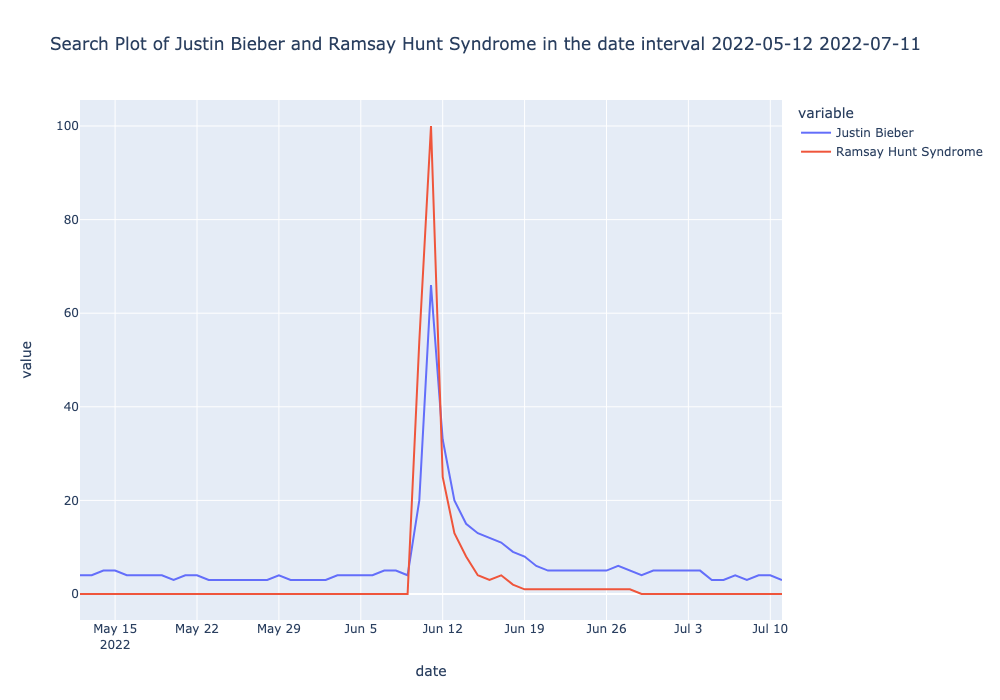

In [ ]:
show_the_trend(df_interest_over_time ,date_interval)

In [ ]:
related_queries_rising, related_queries_top = get_top_and_rising(HPP_related_queries)
df1 = related_queries_top
df2 = related_queries_rising
print(df_interest_over_time.columns[0])
display_side_by_side([df1, df2], [f'Top Related Quires', f'Rising Related Quiries'])

Justin Bieber


,query,value
0,justin,100
1,bieber,95
2,bieber justin bieber,91
3,justin bieber,91
4,beiber,9
5,bieber face,9
6,justin bieber face,8
7,ramsay hunt,7
8,justin bieber paralyzed,6
9,justin beiber,6


In [ ]:
a = f"Top Related Quires for {df_interest_over_time .columns[0]}"
b = f'Rising Related Quiries for {df_interest_over_time .columns[0]}'

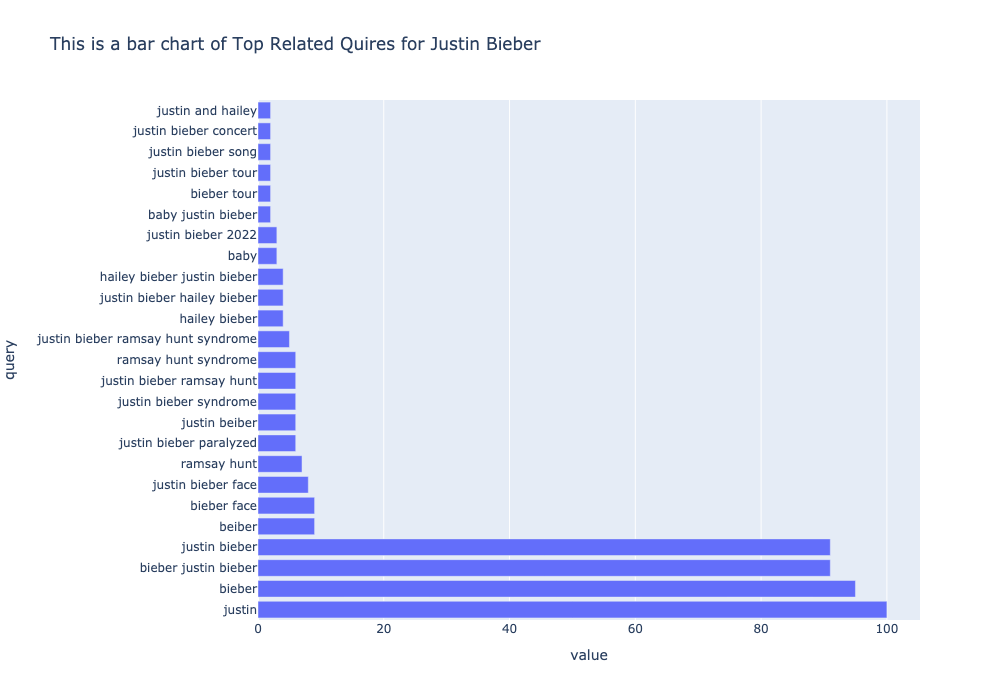

In [ ]:
Topbar_chart(df1, a)

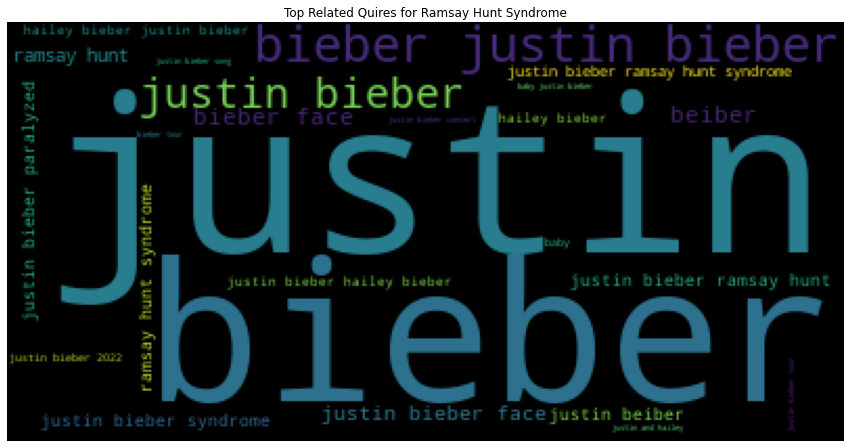

In [ ]:
wordcloud_of_related_queries(df1, f'Top Related Quires for {df_interest_over_time.columns[1]}')

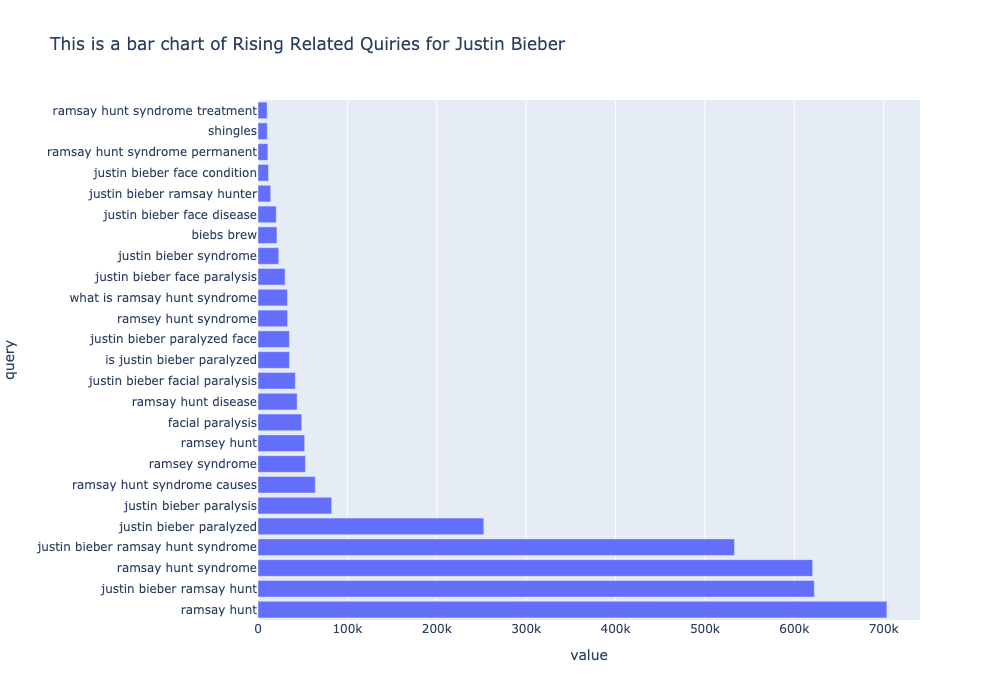

In [ ]:
Risingbar_chart(df2, b)

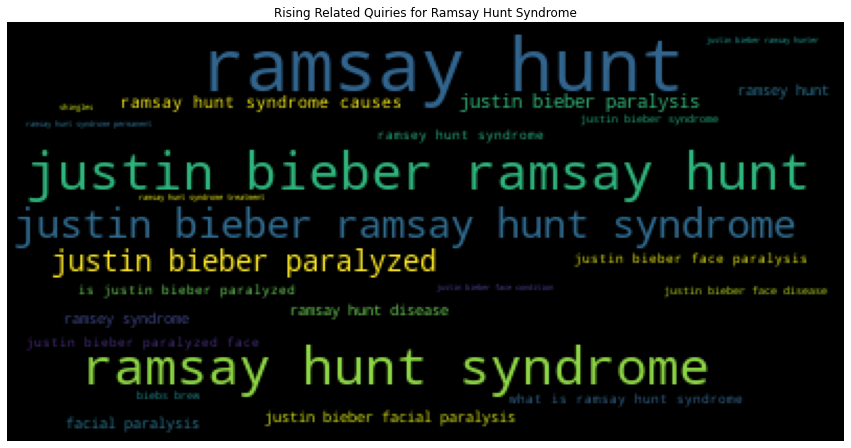

In [ ]:
wordcloud_of_related_queries(df2, f'Rising Related Quiries for {df_interest_over_time.columns[1]}')

In [ ]:
related_queries_rising, related_queries_top = get_top_and_rising(CC_related_queries)
df1 = related_queries_top
df2 = related_queries_rising
print(df_interest_over_time.columns[1])
display_side_by_side([df1, df2], [f'Top Related Quires', f'Rising Related Quiries'])

Lupus


,query,value
0,lupus,100
1,lupus symptoms,14
2,lupus disease,7
3,what is lupus,6
4,sle,5
5,lupus rash,3
6,symptoms of lupus,3
7,selena gomez,3
8,lupus selena gomez,3
9,lupus pain,2


In [ ]:
a = f"Top Related Quires for {df_interest_over_time.columns[1]}"
b = f'Rising Related Quiries for {df_interest_over_time.columns[1]}'

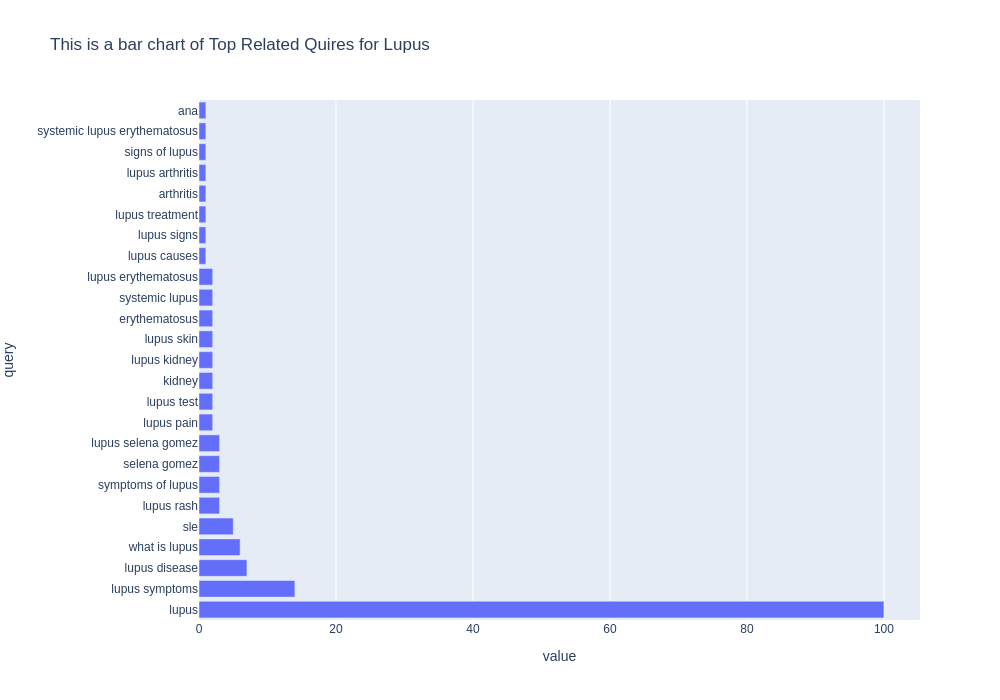

In [ ]:
Topbar_chart(df1, a)

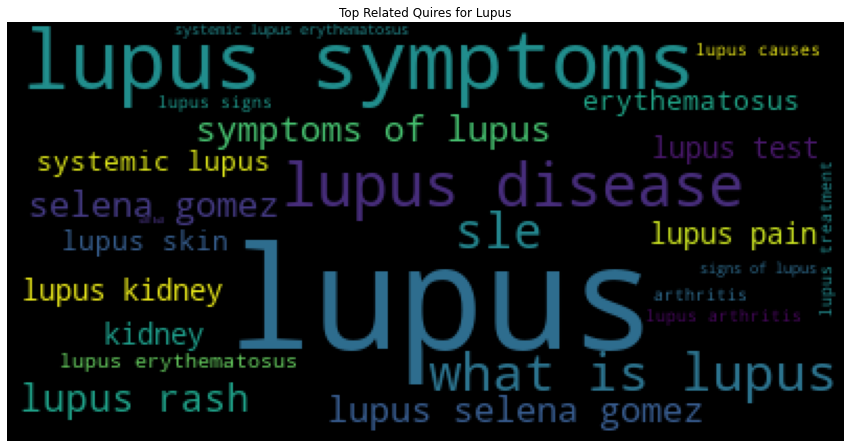

In [ ]:
wordcloud_of_related_queries(df1, f'Top Related Quires for {df_interest_over_time.columns[1]}')

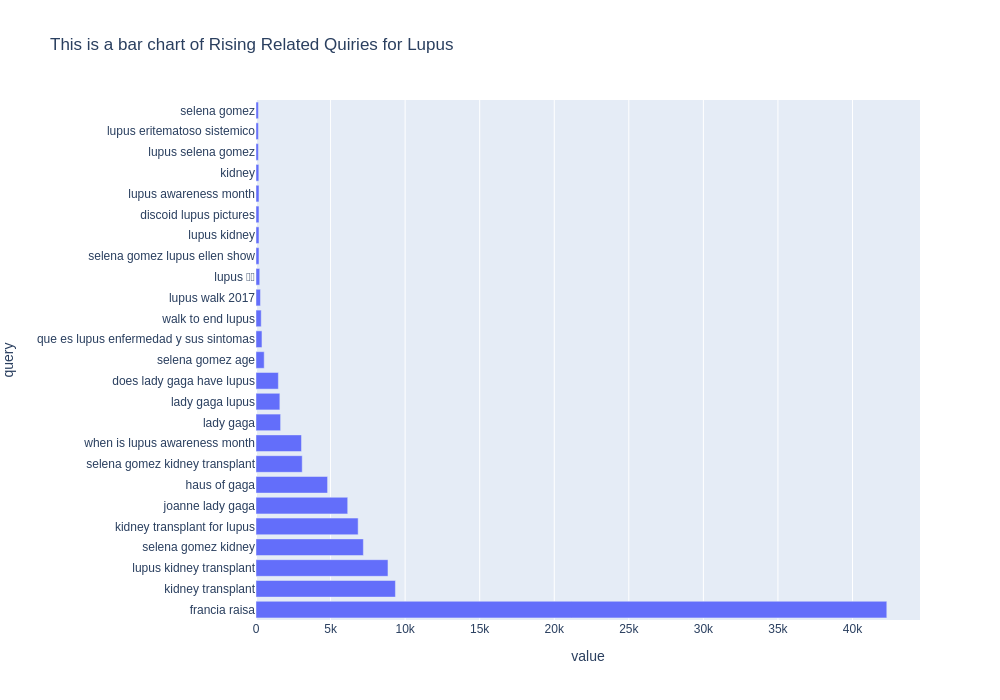

In [ ]:
Risingbar_chart(df2, b)

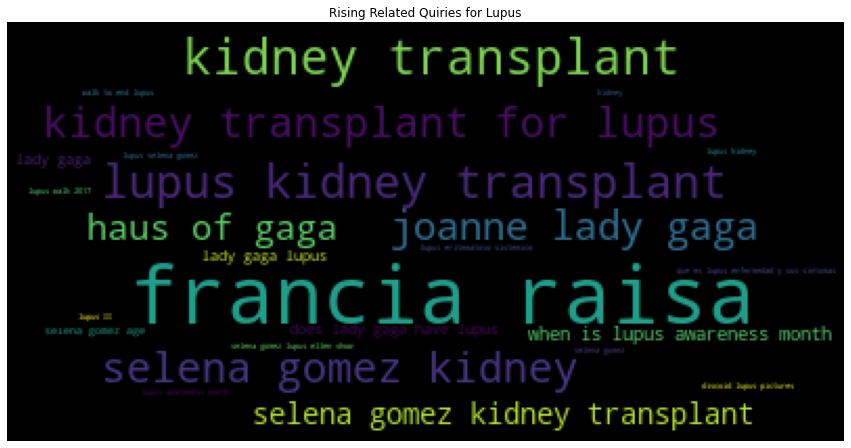

In [ ]:
wordcloud_of_related_queries(df2, f'Rising Related Quiries for {df_interest_over_time.columns[1]}')

In [ ]:
df_region.head()

,State,Selena Gomez,Lupus
0,Alabama,46,54
1,Alaska,50,50
2,Arizona,58,42
3,Arkansas,48,52
4,California,62,38


In [ ]:
temp_data = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-states-territories.csv", encoding= 'unicode_escape')
temp_data = temp_data[["Name","Abbreviation"]]
temp_data["Name"] = temp_data["Name"].str.strip()
temp_data["Abbreviation"] = temp_data["Abbreviation"].str.strip()
temp_data["Name"] = [name.replace( "[E]", "" ) for name in temp_data["Name"]]
code = dict(zip(temp_data['Name'], temp_data['Abbreviation']))
df_region['Code'] = df_region['State'].map(code)

In [ ]:
df_region.head()

,State,Selena Gomez,Lupus,Code
0,Alabama,46,54,AL
1,Alaska,50,50,AK
2,Arizona,58,42,AZ
3,Arkansas,48,52,AR
4,California,62,38,CA


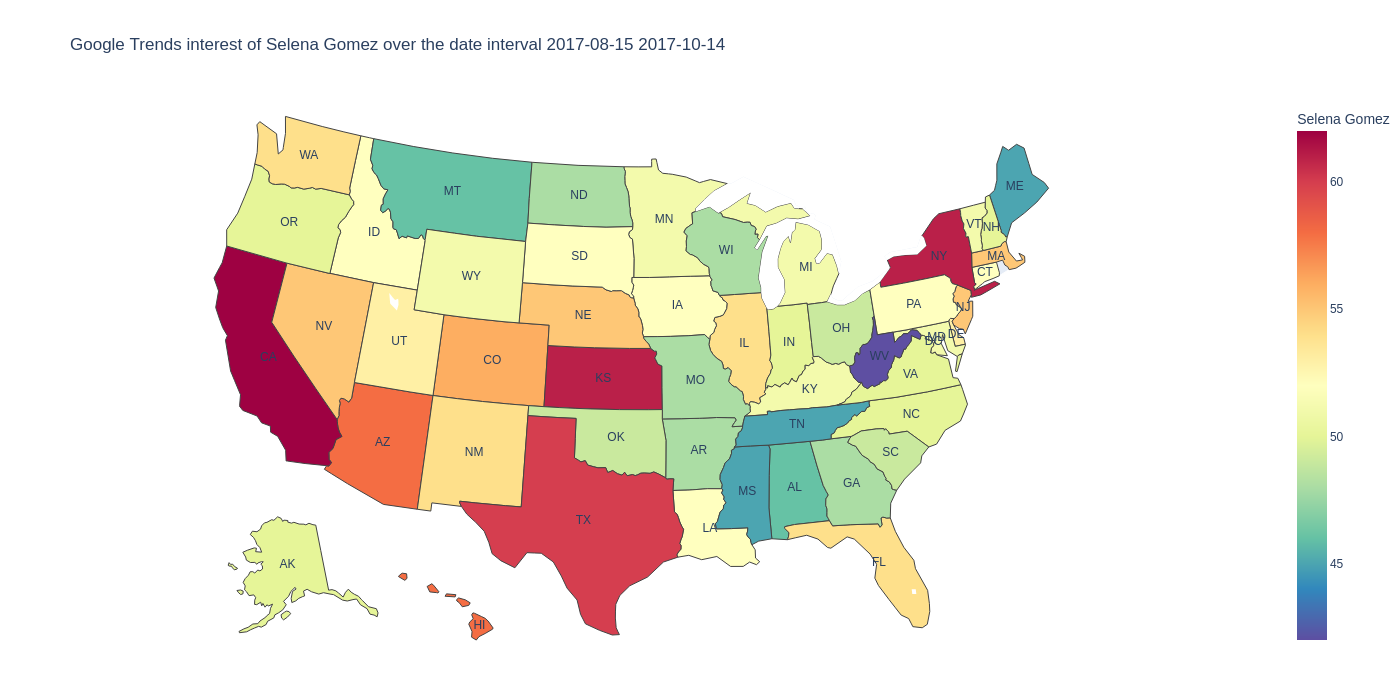

In [ ]:
fig = px.choropleth(df_region, title= f'Google Trends interest of {df_region.columns[1]} over the date interval {date_interval}',
                    locations='Code',
                    color=f'{df_region.columns[1]}',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')

fig.add_scattergeo(
                    locations=df_region['Code'],    ###codes for states,
                    locationmode='USA-states',
                    text=df_region['Code'],
                    mode='text')

fig.update_layout(width=1200, height=600, margin={"r":0,"t":100,"l":0,"b":50},)    
fig.show(renderer='png')
#fig.show()

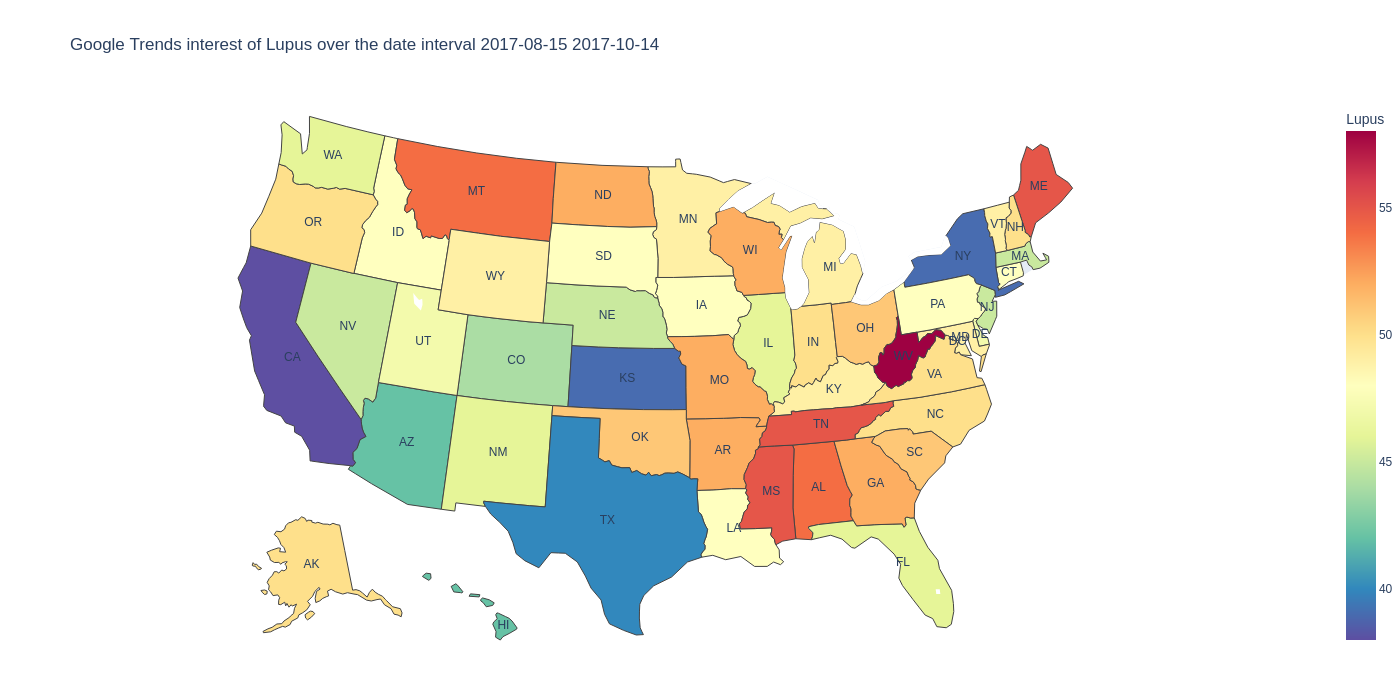

In [ ]:
fig = px.choropleth(df_region,
                    title= f'Google Trends interest of {df_region.columns[2]} over the date interval {date_interval}',
                    locations='Code',
                    color=f'{df_region.columns[2]}',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    scope='usa')
fig.add_scattergeo(
                    locations=df_region['Code'],    ###codes for states,
                    locationmode='USA-states',
                    text=df_region['Code'],
                    mode='text')

fig.update_layout(width=1200, height=600, margin={"r":0,"t":100,"l":0,"b":50},)                   
fig.show(renderer='png')
#fig.show()

## **Conclusion**

The above analysis and visualizations do show a window of heightened awareness based on the search trend demand correlation between the High Profile Person's name and the Chronic Condition. Furthermore, the top related and rising related queries give insights into what the users are searching for related to the HPP and the CC. We see that these queries include any scandals related to the HPP, HPP's wealth, career highlights, spouse, etc., and also when the HPP was diagnosed with the CC, awareness of the CC, signs and symptoms of the CC, introspection over time, testing, survival rates, etc. The next step will be figuring out different ways this information and insights can be used in marketing campaigns, providing accurate information on the CC to the users, and how healthcare providers and other stakeholders take advantage of this window of heightened awareness. 

Please use the link below to checkout the CHM tool and try it out yourself:
https://cultural-health-moments-u9cfatupzdlsap4ax7jahd.streamlit.app
